#### 1. Converting TIFF

In [3]:
import os
import numpy as np
import tifffile
from PIL import Image

# Read the image
imageAll = tifffile.imread('CaSki17.tif')
lengthOfStack = imageAll.shape[0]  # Get the length of the stack
dirToStore = "C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/"

# Check if the directory exists, if not, create it
if not os.path.exists(dirToStore):
    os.makedirs(dirToStore)
else:
    # Clear the directory if it's not empty
    for file in os.listdir(dirToStore):
        os.remove(os.path.join(dirToStore, file))

for index in range(lengthOfStack):  # Loop through each frame
    image = np.array(imageAll[index, :, :], dtype=np.uint16)
    image = Image.fromarray(image) # Convert to PIL Image
    image.save(f"{dirToStore}{index+1}.tif")

<tifffile.TiffTag 5033 @530880> coercing invalid ASCII to bytes


#### 2. Cellpose Detection for one frame

Biggest radius: 55.902 pixels
Diameter: 6.988 microns
Centroid coordinates: 330 233
Bounding rectangle coordinates: 269 173 390 294
Bounding rectangle area dimensions: 121 x 121


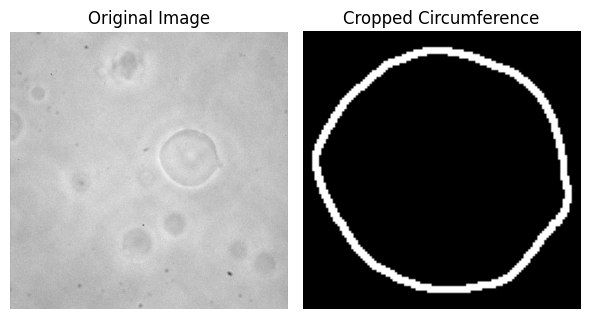

In [4]:
import cv2
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to clear directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

# Function to contrast stretch images
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = ((image - min_val) / (max_val - min_val)) * 255
    return stretched_image.astype(np.uint8)

# Initialize CellPose model
model = models.Cellpose(gpu=True, model_type='cyto')

# Path to image
image_path = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/1.tif'

# Read image
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Segment membranes
masks, _, _, _ = model.eval(image, diameter=None, channels=[0, 0])

# Convert masks to uint16 format
masks_uint16 = masks.astype(np.uint16) * 65535

# Find contours
contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the contour with maximum area
max_contour = max(contours, key=cv2.contourArea)

# Calculate the biggest radius
(x_circle, y_circle), radius = cv2.minEnclosingCircle(max_contour)
print(f"Biggest radius: {radius:.3f} pixels")
diameter_microns = (radius*2)/16
print(f"Diameter: {diameter_microns:.3f} microns")

# Calculate the centroid of the biggest contour
M = cv2.moments(max_contour)
center_x = int(M["m10"] / M["m00"])
center_y = int(M["m01"] / M["m00"])
print("Centroid coordinates:", center_x, center_y)

# Draw the contour of the biggest circle without filling it
circumference_image = np.zeros_like(image)
cv2.drawContours(circumference_image, [max_contour], -1, (255, 255, 255), thickness=2)

# Calculate the bounding rectangle around the contour
x, y, w, h = cv2.boundingRect(max_contour)

# Determine the side length of the square
side_length = max(w, h)

# Create a square bounding box around the circumference
center_x = x + w // 2
center_y = y + h // 2
x_square = center_x - side_length // 2
y_square = center_y - side_length // 2

# Expand the square to ensure it covers the entire circumference
x_square -= 5
y_square -= 5
side_length += 10

print("Bounding rectangle coordinates:", x_square, y_square, x_square + side_length, y_square + side_length)
print("Bounding rectangle area dimensions:", side_length, "x", side_length)

# Crop the circumference image using the square bounding box
cropped_circumference = circumference_image[y_square:y_square+side_length, x_square:x_square+side_length]

# Create a directory for segmented membranes
segmented_membranes_dir = os.path.join(os.getcwd(), "Segmented Membranes")
create_directory(segmented_membranes_dir)
# Clear the directory if it's not empty
clear_directory(segmented_membranes_dir)

# Save cropped segmented circumference in tif format
cv2.imwrite(os.path.join(segmented_membranes_dir, "cropped_circumference.tif"), cropped_circumference)

# Display images
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_circumference, cmap='gray')
plt.title('Cropped Circumference')
plt.axis('off')

plt.tight_layout()
plt.show()


### Iterative Segmentation

In [13]:
import cv2
from cellpose import models
import numpy as np
import os
import shutil
import time
import json

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to clear the contents of a directory
def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))

model = models.Cellpose(gpu=True, model_type='cyto')
input_directory = 'C:/Users/mkana/Desktop/GPMV/GPMV_new/SingleTiffs/'
output_directory = os.path.join(os.getcwd(), "Segmented Membranes")
create_directory(output_directory)
clear_directory(output_directory)
log_file_path = os.path.join(output_directory, "Caski17_log.json")

data_for_all_frames = []
counter = 1
diameters = []  # List to store diameters
frame_start, frame_end = 0.0, 0.0
time_counter = True

for filename in sorted(os.listdir(input_directory)):
    if filename.endswith(".tif"):
        image_path = os.path.join(input_directory, filename)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        # Normalize the image
        image_normalized = cv2.normalize(image, None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        if image.dtype == np.uint16:
            image_clahe = clahe.apply(image_normalized)
        else:
            image_clahe = clahe.apply((image_normalized / 256).astype(np.uint8))

        # Apply Gaussian Blurring
        image_blurred = cv2.GaussianBlur(image_clahe, (5, 5), 0)

        if time_counter:
            frame_start = time.time()

        masks, _, _, _ = model.eval(image_blurred, diameter=None, channels=[0, 0])

        if time_counter:
            time_counter = False
            frame_end = time.time()
            total_seconds = frame_end - frame_start
            minutes, seconds = divmod(total_seconds, 60)
            print(f'Frame elapsed time = {int(minutes)}m {seconds:.5f}s')

        contours, _ = cv2.findContours(masks.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_contour = max(contours, key=cv2.contourArea)
        (x_circle, y_circle), radius = cv2.minEnclosingCircle(max_contour)
        diameter = (radius * 2)
        diameters.append(diameter)  # Append diameter to the list
        M = cv2.moments(max_contour)
        center_x = int(M["m10"] / M["m00"])
        center_y = int(M["m01"] / M["m00"])

        frame_data = {
            "frame_number": counter,
            "centroid": [center_x, center_y],
            "circumference_coordinates": max_contour.reshape(-1, 2).tolist(),
            "diameter": diameter
        }
        data_for_all_frames.append(frame_data)

        # Image processing and logging
        circumference_image = np.zeros_like(image)
        cv2.drawContours(circumference_image, [max_contour], -1, (255, 255, 255), thickness=2)
        x, y, w, h = cv2.boundingRect(max_contour)
        side_length = max(w, h)
        x_square = max(0, center_x - 75)
        y_square = max(0, center_y - 75)
        side_length = min(min(image.shape[0] - y_square, image.shape[1] - x_square), 150)
        cropped_circumference = circumference_image[y_square:y_square+side_length, x_square:x_square+side_length]
        cv2.imwrite(os.path.join(output_directory, f"{counter:03d}_cropped_circumference.tif"), cropped_circumference)
        counter += 1

# Write the collected data to a JSON file
with open(log_file_path, 'w') as log_file:
    json.dump(data_for_all_frames, log_file)

# Calculate the average diameter from the 'diameters' list and convert to microns
average_diameter_microns = np.mean(diameters) / 16  
print(f"Average Diameter: {average_diameter_microns:.3f} microns")


Frame elapsed time = 0m 4.68879s
Average Diameter: 7.268 microns


#### Creating a GIF file 

In [15]:
import os
import imageio.v2 as imageio

# Output directory for segmented membranes
output_directory = os.path.join(os.getcwd(), "Segmented Membranes")

# List cropped circumferences paths
cropped_paths = [os.path.join(output_directory, filename) for filename in sorted(os.listdir(output_directory)) if filename.endswith(".tif")]

# Create GIF from cropped circumferences
gif_output_path = os.path.join(output_directory, "cropped_circumferences.gif")

# Delete the existing GIF file if it exists
if os.path.exists(gif_output_path):
    os.remove(gif_output_path)
    print(f"Existing GIF file '{gif_output_path}' deleted.")

with imageio.get_writer(gif_output_path, mode='I') as writer:
    for path in cropped_paths:
        image = imageio.imread(path)
        writer.append_data(image)

print("GIF created successfully.")

Existing GIF file 'C:\Users\mkana\Desktop\GPMV\GPMV_new\Segmented Membranes\cropped_circumferences.gif' deleted.
GIF created successfully.
